<a href="https://colab.research.google.com/github/gireesh66/pytorch-language-model/blob/main/Neural_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
import random

# For reproducibility
torch.manual_seed(1234)
np.random.seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

print("Imports and setup complete.")

Imports and setup complete.


In [36]:
def split_data(original_file_path="Pride_and_Prejudice-Jane_Austen.txt"):
    """
    Reads the original text file and splits it into 80% train,
    10% validation, and 10% test sets.
    """
    train_file_path = "train.txt"
    valid_file_path = "valid.txt"
    test_file_path = "test.txt"

    val_split = 0.1
    test_split = 0.1

    try:
        with open(original_file_path, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]

        print(f"Read {len(lines)} non-empty lines from {original_file_path}")

        # Shuffle the lines
        random.shuffle(lines)

        # Determine split indices
        total_lines = len(lines)
        val_count = int(total_lines * val_split)
        test_count = int(total_lines * test_split)

        test_data = lines[:test_count]
        val_data = lines[test_count : test_count + val_count]
        train_data = lines[test_count + val_count :]

        # Write the split files
        def write_file(filepath, data):
            with open(filepath, 'w', encoding='utf-8') as f:
                for line in data:
                    f.write(line + '\n')
            print(f"Wrote {len(data)} lines to {filepath}")

        write_file(train_file_path, train_data)
        write_file(valid_file_path, val_data)
        write_file(test_file_path, test_data)

        print("\nSuccessfully split data!")
        return "." # Return the path (current directory)

    except FileNotFoundError:
        print(f"ERROR: The file '{original_file_path}' was not found.")
        print("Please make sure it's uploaded to your Colab environment.")
        return None

# --- Execute the split ---
corpus_path = split_data()

Read 11170 non-empty lines from Pride_and_Prejudice-Jane_Austen.txt
Wrote 8936 lines to train.txt
Wrote 1117 lines to valid.txt
Wrote 1117 lines to test.txt

Successfully split data!


In [37]:
from collections import Counter

class Dictionary(object):
    """Maps words to indices and vice-versa."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        # Add the <unk> token first
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

class Corpus(object):
    """Reads and tokenizes the dataset files, handling rare words."""
    def __init__(self, path, vocab_threshold=3):
        self.dictionary = Dictionary()

        # 1. Build a word frequency counter from training data
        word_counts = Counter()
        with open(os.path.join(path, 'train.txt'), 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                word_counts.update(words)

        # 2. Build the dictionary ONLY with common words
        for word, count in word_counts.items():
            if count >= vocab_threshold:
                self.dictionary.add_word(word)

        print(f"Original word count: {len(word_counts)}")
        print(f"New vocabulary size (threshold={vocab_threshold}): {len(self.dictionary)}")

        # 3. Tokenize all three splits using the new, smaller dictionary
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file into a 1D tensor of IDs."""
        assert os.path.exists(path)
        unk_idx = self.dictionary.word2idx['<unk>']

        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    # If word is in our dictionary, use its ID
                    if word in self.dictionary.word2idx:
                        ids.append(self.dictionary.word2idx[word])
                    # Otherwise, use the <unk> token's ID
                    else:
                        ids.append(unk_idx)
                idss.append(torch.tensor(ids).type(torch.int64))
        # Concatenate all lines into one long sequence
        ids = torch.cat(idss)
        return ids

print("Dictionary and Corpus classes (with <unk> handling) defined.")

Dictionary and Corpus classes (with <unk> handling) defined.


In [38]:
def batchify(data, bsz, device):
    """
    Reshapes the 1D data tensor into (nbatch, bsz) dimensions.
    The data is divided into `bsz` columns.
    """
    # Calculate how many full batches we can make
    nbatch = data.size(0) // bsz
    # Trim off any extra data that doesn't fit
    data = data.narrow(0, 0, nbatch * bsz)
    # Reshape into bsz columns
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

def get_batch(source, i, bptt_len):
    """
    Subdivides the source data into chunks of length bptt_len (sequence length).
    """
    # Set the sequence length
    seq_len = min(bptt_len, len(source) - 1 - i)
    # Get the data (input)
    data = source[i:i+seq_len]
    # Get the target (the next word, shifted by 1)
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

print(" Batching functions defined.")

 Batching functions defined.


In [39]:
class LanguageModel(nn.Module):
    """A from-scratch LSTM-based Language Model."""
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        """
        ntoken: vocab_size
        ninp: embedding dimension
        nhid: number of hidden units in LSTM
        nlayers: number of LSTM layers
        """
        super(LanguageModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        # 1. Embedding Layer: Converts word indices to vectors
        self.encoder = nn.Embedding(ntoken, ninp)
        # 2. LSTM Layer: The core sequence processing unit
        self.lstm = nn.LSTM(ninp, nhid, nlayers, dropout=dropout, bidirectional=True )
        # 3. Decoder (Linear) Layer: Maps LSTM output back to vocab space
        # FIX: The output of a bidirectional LSTM has nhid * 2 features
        self.decoder = nn.Linear(nhid * 2, ntoken)

        self.init_weights()
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken # vocab_size

    def init_weights(self):
        """Initializes weights with a uniform distribution."""
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        # input shape: (seq_len, batch_size)
        emb = self.drop(self.encoder(input))
        # emb shape: (seq_len, batch_size, embedding_dim)

        output, hidden = self.lstm(emb, hidden)
        # output shape: (seq_len, batch_size, hidden_dim * num_directions)

        output = self.drop(output)
        # 3. Decode the output
        decoded = self.decoder(output)
        # decoded shape: (seq_len, batch_size, vocab_size)

        # Reshape for CrossEntropyLoss
        return decoded.view(-1, self.ntoken), hidden

    def init_hidden(self, bsz):
        """Initializes a fresh hidden state (h_0, c_0) for the LSTM."""
        weight = next(self.parameters())
        # (num_layers * num_directions, batch_size, hidden_dim)
        # For bidirectional, num_directions is 2
        # The LSTM is initialized with bidirectional=True, so num_directions should always be 2.
        num_directions = 2
        return (weight.new_zeros(self.nlayers * num_directions, bsz, self.nhid),
                weight.new_zeros(self.nlayers * num_directions, bsz, self.nhid))

In [40]:
class previous_changes_lmodel(nn.Module):
    """A from-scratch LSTM-based Language Model."""
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        """
        ntoken: vocab_size
        ninp: embedding dimension
        nhid: number of hidden units in LSTM
        nlayers: number of LSTM layers
        """
        super(previous_changes_lmodel, self).__init__()
        self.drop = nn.Dropout(dropout)
        # 1. Embedding Layer: Converts word indices to vectors
        self.encoder = nn.Embedding(ntoken, ninp)
        # 2. LSTM Layer: The core sequence processing unit
        self.lstm = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        # 3. Decoder (Linear) Layer: Maps LSTM output back to vocab space
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken # vocab_size

    def init_weights(self):
        """Initializes weights with a uniform distribution."""
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        # input shape: (seq_len, batch_size)
        emb = self.drop(self.encoder(input))
        # emb shape: (seq_len, batch_size, embedding_dim)

        output, hidden = self.lstm(emb, hidden)
        # output shape: (seq_len, batch_size, hidden_dim)

        output = self.drop(output)
        # 3. Decode the output
        decoded = self.decoder(output)
        # decoded shape: (seq_len, batch_size, vocab_size)

        # Reshape for CrossEntropyLoss
        return decoded.view(-1, self.ntoken), hidden

    def init_hidden(self, bsz):
        """Initializes a fresh hidden state (h_0, c_0) for the LSTM."""
        weight = next(self.parameters())
        # (num_layers, batch_size, hidden_dim)
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

print(" LanguageModel (LSTM) class defined.")

 LanguageModel (LSTM) class defined.


In [41]:
def detach_hidden(hidden):
    """
    Detaches the hidden state from the computation graph.
    This prevents backpropagating all the way to the beginning of the dataset.
    """
    return (hidden[0].detach(), hidden[1].detach())


def train(model, train_data, optimizer, criterion, bptt_len, batch_size):
    """Runs one epoch of training."""
    model.train() # Set model to training mode
    total_loss = 0.
    start_time = time.time()
    # Initialize hidden state at the start of the epoch
    hidden = model.init_hidden(batch_size)

    # Loop over the data in chunks of bptt_len
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt_len)):
        data, targets = get_batch(train_data, i, bptt_len)

        # --- Core Training Steps ---
        optimizer.zero_grad()
        hidden = detach_hidden(hidden) # Detach from previous history

        output, hidden = model(data, hidden) # Forward pass
        loss = criterion(output, targets) # Calculate loss

        loss.backward() # Backward pass

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step() # Update weights
        # --- End Core Steps ---

        total_loss += loss.item()

    # Return average loss for the epoch
    return total_loss / (batch + 1)


def evaluate(model, data_source, criterion, bptt_len, eval_batch_size):
    """Evaluates the model on the validation or test set."""
    model.eval() # Set model to evaluation mode
    total_loss = 0.
    # Initialize hidden state
    hidden = model.init_hidden(eval_batch_size)

    with torch.no_grad(): # No gradients needed for evaluation
        for i in range(0, data_source.size(0) - 1, bptt_len):
            data, targets = get_batch(data_source, i, bptt_len)
            output, hidden = model(data, hidden)
            hidden = detach_hidden(hidden)
            # Sum up the loss
            total_loss += len(data) * criterion(output, targets).item()

    # Return average loss per token
    return total_loss / (len(data_source) - 1)

print("Cell 6: Train and evaluate functions defined.")

Cell 6: Train and evaluate functions defined.


In [42]:
# (UNDERFITTING) ===

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Batch Data ---
if corpus_path:
    corpus = Corpus(corpus_path)
    vocab_size = len(corpus.dictionary)
    print(f"Vocabulary size: {vocab_size}")

    batch_size = 20
    eval_batch_size = 10
    bptt_len = 35 # Sequence length

    train_data = batchify(corpus.train, batch_size, device)
    val_data = batchify(corpus.valid, eval_batch_size, device)
    test_data = batchify(corpus.test, eval_batch_size, device)
else:
    print("Corpus path not set. Please re-run Cell 2.")

# === HYPERPARAMETERS (UNDERFITTING) ===

emsize = 20     # VERY SMALL embedding dimension
nhid = 50       # VERY SMALL hidden dimension
nlayers = 1     # ONLY ONE layer
dropout = 0.0
epochs = 5     # Train for many epochs
lr = 0.001

# --- Build model, loss, and optimizer ---
model = previous_changes_lmodel(vocab_size, emsize, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- Run Training Loop ---
best_val_loss = float('inf')
train_losses = []
val_losses = []
model_save_path = 'underfit_model.pt' # Save to a new file

print("\nStarting training for UNDERFITTING...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    avg_train_loss = train(model, train_data, optimizer, criterion, bptt_len, batch_size)
    val_loss = evaluate(model, val_data, criterion, bptt_len, eval_batch_size)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    val_perplexity = math.exp(val_loss)

    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid perplexity {val_perplexity:8.2f}')
    print('-' * 89)

    # Save the model (though for underfitting, it's not very useful)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(model_save_path, 'wb') as f:
            torch.save(model, f)

print("Training complete.")



Using device: cuda
Original word count: 12184
New vocabulary size (threshold=3): 3576
Vocabulary size: 3576

Starting training for UNDERFITTING...
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.38s | valid loss  5.62 | valid perplexity   275.05
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  0.35s | valid loss  5.59 | valid perplexity   268.67
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  0.37s | valid loss  5.54 | valid perplexity   255.16
-----------------------------------------------------------------------------------------
----------------------------------------------------------------------

Generating loss plot...


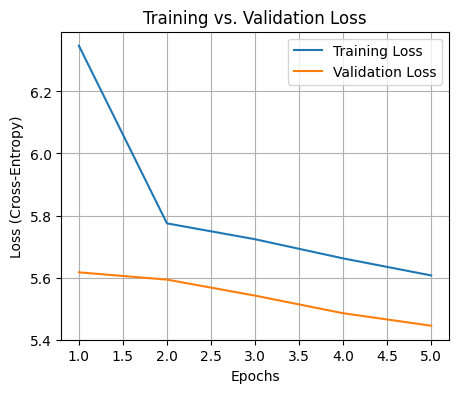

Plot saved.


In [43]:
# === CELL 8 (Plotting) ===

print("Generating loss plot...")
plt.figure(figsize=(5, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('underfit_plot.png')
plt.show()

print("Plot saved.")

In [44]:
# === CELL 7 (OVERFITTING) ===

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Batch Data ---
if corpus_path:
    corpus = Corpus(corpus_path)
    vocab_size = len(corpus.dictionary)
    print(f"Vocabulary size: {vocab_size}")

    batch_size = 20
    eval_batch_size = 10
    bptt_len = 35 # Sequence length

    train_data = batchify(corpus.train, batch_size, device)
    val_data = batchify(corpus.valid, eval_batch_size, device)
    test_data = batchify(corpus.test, eval_batch_size, device)
else:
    print("Corpus path not set. Please re-run Cell 2.")

# === HYPERPARAMETERS (OVERFITTING) ===
emsize = 400    # LARGE embedding dimension
nhid = 400      # LARGE hidden dimension
nlayers = 2
dropout = 0.0   # NO DROPOUT (this is key)
epochs = 30     # MANY epochs
lr = 0.001


# --- Build model, loss, and optimizer ---
model = previous_changes_lmodel(vocab_size, emsize, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- Run Training Loop ---
best_val_loss = float('inf')
train_losses = []
val_losses = []
model_save_path = 'overfit_model.pt' # Save to a new file

print("\nStarting training for OVERFITTING...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    avg_train_loss = train(model, train_data, optimizer, criterion, bptt_len, batch_size)
    val_loss = evaluate(model, val_data, criterion, bptt_len, eval_batch_size)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    val_perplexity = math.exp(val_loss)

    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid perplexity {val_perplexity:8.2f}')
    print('-' * 89)

    # We save the model with the best *validation* loss,
    # even though it will be from an earlier epoch.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(model_save_path, 'wb') as f:
            torch.save(model, f)

print("Training complete.")



Using device: cuda
Original word count: 12184
New vocabulary size (threshold=3): 3576
Vocabulary size: 3576

Starting training for OVERFITTING...
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.71s | valid loss  5.31 | valid perplexity   203.27
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.72s | valid loss  4.94 | valid perplexity   139.09
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  1.73s | valid loss  4.76 | valid perplexity   117.20
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------

Generating loss plot...


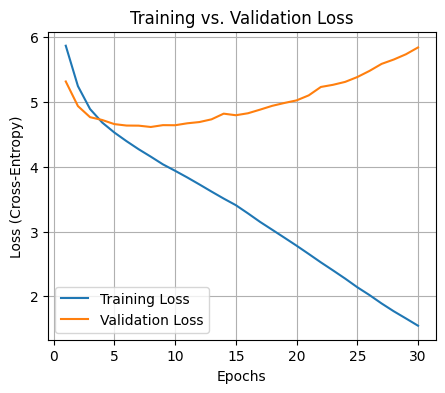

Plot saved.


In [45]:
print("Generating loss plot...")
plt.figure(figsize=(5, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('overfit_plot.png')
plt.show()

print("Plot saved.")

In [46]:
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Batch Data ---
if corpus_path:
    corpus = Corpus(corpus_path)
    vocab_size = len(corpus.dictionary)
    print(f"Vocabulary size: {vocab_size}")

    batch_size = 20
    eval_batch_size = 10
    bptt_len = 35 # Sequence length

    train_data = batchify(corpus.train, batch_size, device)
    val_data = batchify(corpus.valid, eval_batch_size, device)
    test_data = batchify(corpus.test, eval_batch_size, device)
else:
    print("Corpus path not set. Please re-run Cell 2.")


# "BEST FIT" Parameters[cite: 19]:
emsize = 200   # embedding dimension
nhid = 200      # hidden dimension
nlayers = 2    # number of layers
dropout = 0.2  # dropout rate for regularization
epochs = 40
lr = 0.001      # learning rate

# --- Build model, loss, and optimizer ---
model = LanguageModel(vocab_size, emsize, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# --- Run Training Loop ---
best_val_loss = float('inf')
train_losses = []
val_losses = []
model_save_path = 'best_model.pt'

print("\nStarting training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    avg_train_loss = train(model, train_data, optimizer, criterion, bptt_len, batch_size)
    val_loss = evaluate(model, val_data, criterion, bptt_len, eval_batch_size)

    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    # Calculate perplexity
    val_perplexity = math.exp(val_loss)

    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid perplexity {val_perplexity:8.2f}')
    print('-' * 89)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(model_save_path, 'wb') as f:
            torch.save(model, f)
            print(f"Saved best model to {model_save_path}")

    scheduler.step() # Adjust learning rate

print("Training complete.")

Using device: cuda
Original word count: 12184
New vocabulary size (threshold=3): 3576
Vocabulary size: 3576

Starting training...
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.34s | valid loss  3.78 | valid perplexity    43.79
-----------------------------------------------------------------------------------------
Saved best model to best_model.pt
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.35s | valid loss  2.46 | valid perplexity    11.75
-----------------------------------------------------------------------------------------
Saved best model to best_model.pt
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  1.34s | valid loss  1.86 | valid perplexity     6.40
-----------------------------------------------------------------------------------------
Saved best model to

Generating loss plot...


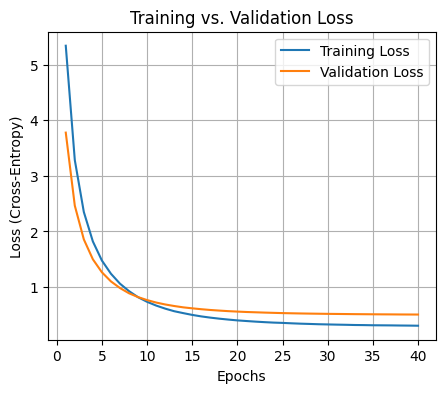

Plot saved.


In [47]:
print("Generating loss plot...")
plt.figure(figsize=(5, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('bestfit_plot.png')
plt.show()

print("Plot saved.")

In [48]:
# === CELL 9 (Final Evaluation) ===

print("\nLoading best model for final test evaluation...")

# Define the model save path again just in case
model_save_path = 'best_model.pt'

try:
    # Load the saved model
    with open(model_save_path, 'rb') as f:

        # --- FIX IS HERE ---
        # We add 'weights_only=False' to tell PyTorch it's safe
        # to load our custom 'LanguageModel' class.
        best_model = torch.load(f, map_location=device, weights_only=False)
        # --- END FIX ---

    # Run evaluation on the unseen test data
    test_loss = evaluate(best_model, test_data, criterion, bptt_len, eval_batch_size)
    test_perplexity = math.exp(test_loss)

    print('=' * 89)
    print(f'| End of training | test loss {test_loss:5.2f} | '
          f'test perplexity {test_perplexity:8.2f}')
    print('=' * 89)

    print("\n--- ASSIGNMENT COMPLETE ---")
    print(f"Final Test Perplexity (for your report): {test_perplexity:8.2f}")
    print("\nDeliverables created:")
    print("1. This notebook (your code).")
    print("2. 'underfit_plot.png'")
    print("3. 'overfit_plot.png'")
    print("4. 'best_fit_plot.png'")
    print("5. 'best_model.pt' (your trained model).")

except FileNotFoundError:
    print(f"ERROR: '{model_save_path}' not found. Did training in Cell 7 complete and save the model?")
except NameError as e:
    print(f"ERROR: A variable might not be defined. {e}")
    print("Please make sure you have run all previous cells (especially Cell 3 for 'criterion', Cell 4 for 'test_data', etc.)")


Loading best model for final test evaluation...
| End of training | test loss  0.49 | test perplexity     1.63

--- ASSIGNMENT COMPLETE ---
Final Test Perplexity (for your report):     1.63

Deliverables created:
1. This notebook (your code).
2. 'underfit_plot.png'
3. 'overfit_plot.png'
4. 'best_fit_plot.png'
5. 'best_model.pt' (your trained model).
